<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/03b_NLP_and_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained Word Embeddings and RNNs

In [0]:
import torch
import torch.optim as optim
from torchtext import data

SEED = 3773

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

## IMDB Reviews Dataset

In [0]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [0]:
print("Number of training examples: {}".format(len(train_data)))
print("Number of testing examples: {}".format(len(test_data)))

Number of training examples: 25000
Number of testing examples: 25000


In [0]:
print(vars(train_data.examples[0]))

## Training, Validation and Testing Sets

In [0]:
import random

train_data, valid_data = train_data.split(
    random_state=random.seed(SEED),
    split_ratio=0.8
)

print("Number of training examples: {}".format(len(train_data)))
print("Number of validation examples: {}".format(len(valid_data)))
print("Number of testing examples: {}".format(len(test_data)))

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000


## Vocabulary and Pre-Trained Embedding (Glove)

In [0]:
MAX_VOCAB_SIZE = 8185

TEXT.build_vocab(train_data,
                 max_size=MAX_VOCAB_SIZE,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [0]:
print("Unique tokens in TEXT vocabulary: {}".format(len(TEXT.vocab)))
print("Unique tokens in LABEL vocabulary: {}".format(len(LABEL.vocab)))

Unique tokens in TEXT vocabulary: 8187
Unique tokens in LABEL vocabulary: 2


In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 231809), (',', 220371), ('.', 189109), ('and', 125051), ('a', 124896), ('of', 115113), ('to', 106993), ('is', 87293), ('in', 70277), ('I', 62182), ('it', 61243), ('that', 56426), ('"', 50797), ("'s", 49824), ('this', 48348), ('-', 42373), ('/><br', 40725), ('was', 39931), ('as', 34758), ('with', 34204)]


In [0]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [0]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f7f47ddf268>, {'pos': 0, 'neg': 1})


In [0]:
BATCH_SIZE = 64
N_EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device
)

## Sequence Processing with RNNs using LSTM

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_dim, output_dim,
                 n_layers, bidirectional):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sequences):

        # sequences: (max sequences length, batch size)
        seq_embeddings = self.embedding(sequences)

        # seq_embeddings: (max sequences length, batch size, embedding dim)
        seq_hidden, (hidden, cell) = self.rnn(seq_embeddings)

        # hidden: (num_layers * num_directions, batch size, hidden dim)
        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        # hidden_concat: (batch size, num_directions * hidden dim)
        output = self.fc(hidden_concat)

        # output: (batch size, 1) -> vector
        return output

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Model 1: 1 bidrectional layer, no pre-trained embeddings

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True

model_v1 = RNN(INPUT_DIM,
               EMBEDDING_DIM,
               HIDDEN_DIM,
               OUTPUT_DIM,
               N_LAYERS,
               BIDIRECTIONAL)

In [0]:
print("The model has {:,} trainable parameters".format(count_parameters(model_v1)))

The model has 1,552,397 trainable parameters


## Model 2: 1 bidirectional layer, pre-trained embeddings (Glove)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True

model_v2 = RNN(INPUT_DIM,
               EMBEDDING_DIM,
               HIDDEN_DIM,
               OUTPUT_DIM,
               N_LAYERS,
               BIDIRECTIONAL)


pretrained_embeddings = TEXT.vocab.vectors
model_v2.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1285, -0.7403, -0.7101,  ...,  0.0324, -0.4687,  1.6241],
        [ 0.3661, -0.2995, -0.1835,  ..., -2.0702,  1.9870,  1.3561],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.1997,  0.6308,  0.8433,  ..., -0.1942,  0.3807,  1.0799],
        [-0.6356,  0.2286,  0.2342,  ..., -0.3992, -0.1603,  0.0763],
        [-0.3978,  0.3323, -0.4064,  ..., -0.5330,  0.5700, -0.5076]])

In [0]:
print("The model has {:,} trainable parameters".format(count_parameters(model_v2)))

The model has 1,552,397 trainable parameters


## Model 3: 1 bidirectional layer, Glove, frozen embeddings layer

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True

model_v3 = RNN(INPUT_DIM,
               EMBEDDING_DIM,
               HIDDEN_DIM,
               OUTPUT_DIM,
               N_LAYERS,
               BIDIRECTIONAL)


pretrained_embeddings = TEXT.vocab.vectors
model_v3.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1285, -0.7403, -0.7101,  ...,  0.0324, -0.4687,  1.6241],
        [ 0.3661, -0.2995, -0.1835,  ..., -2.0702,  1.9870,  1.3561],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.1997,  0.6308,  0.8433,  ..., -0.1942,  0.3807,  1.0799],
        [-0.6356,  0.2286,  0.2342,  ..., -0.3992, -0.1603,  0.0763],
        [-0.3978,  0.3323, -0.4064,  ..., -0.5330,  0.5700, -0.5076]])

In [0]:
embedding_params = sum(p.numel() for p in model_v3.embedding.parameters() if p.requires_grad)

for parameter in model_v3.embedding.parameters():
    parameter.requires_grad = False

print("The model's embedding layer has {:,} parameters".format(embedding_params))
print("The model has {:,} trainable parameters".format(count_parameters(model_v3)))

The model's embedding layer has 818,700 parameters
The model has 733,697 trainable parameters


## Model 4: 2 bidirectional LSTM layers, pre-trained embeddings (Glove)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True

model_v4 = RNN(INPUT_DIM,
               EMBEDDING_DIM,
               HIDDEN_DIM,
               OUTPUT_DIM,
               N_LAYERS,
               BIDIRECTIONAL)


pretrained_embeddings = TEXT.vocab.vectors
model_v4.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1285, -0.7403, -0.7101,  ...,  0.0324, -0.4687,  1.6241],
        [ 0.3661, -0.2995, -0.1835,  ..., -2.0702,  1.9870,  1.3561],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.1997,  0.6308,  0.8433,  ..., -0.1942,  0.3807,  1.0799],
        [-0.6356,  0.2286,  0.2342,  ..., -0.3992, -0.1603,  0.0763],
        [-0.3978,  0.3323, -0.4064,  ..., -0.5330,  0.5700, -0.5076]])

In [0]:
print("The model has {:,} trainable parameters".format(count_parameters(model_v4)))

The model has 3,129,357 trainable parameters


## Training the RNNs

### Loss function: Binary Cross Entropy

For each model we are using 1 neuron in our last layer, and therefore we'll be using the sigmoid function as the activation:

$$ \large h_ w (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^- w^Tx }  $$ 

The probabilty distribution for the positive comments is modeled using the sigmoid function:

$$ P(y=1 | x; W) =  h_ w (x)  $$ 

In [0]:
criterion = nn.BCEWithLogitsLoss()

criterion = criterion.to(device)

### Accuracy function

In [0]:
def accuracy(outputs, labels):
    """
    Returns accuracy per batch

    """

    # Precit y = 1 if sigmoid(output) >= 0.5 (positive review)
    # Precit y = 0 if sigmoid(output) <  0.5 (negative review)
    predictions = torch.round(torch.sigmoid(outputs))
    correct = (predictions == labels).float()
    return correct.sum().item(), len(labels)

### Train function

In [0]:
def train(model, iterator, optimizer, cruterion):
    
    epoch_loss = 0
    epoch_total_correct = 0
    epoch_total_examples = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        outputs = model(batch.text).squeeze(1)

        loss = criterion(outputs, batch.label)

        num_correct, num_examples = accuracy(outputs, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_total_correct += num_correct
        epoch_total_examples += num_examples

    return epoch_loss / len(iterator), epoch_total_correct / epoch_total_examples

### Evaluation function

In [0]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_total_correct = 0
    epoch_total_examples = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            outputs = model(batch.text).squeeze(1)

            loss = criterion(outputs, batch.label)

            num_correct, num_examples = accuracy(outputs, batch.label)

            epoch_loss += loss.item()
            epoch_total_correct += num_correct
            epoch_total_examples += num_examples

    return epoch_loss / len(iterator), epoch_total_correct / epoch_total_examples

### Epoch Timer

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins, elapsed_secs = divmod(int(elapsed_time), 60)
    return elapsed_mins, elapsed_secs

### Training-Evaluation function

In [0]:
def train_evaluate(model, optimizer, criterion, n_epochs):

    metrics = {
        "train_accu": [],
        "train_loss": [],
        "valid_accu": [],
        "valid_loss": [],
    }

    model = model.to(device)

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss, train_accu = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_accu = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print("Epoch: {:02} | Epoch Time: {}m {}s".format(epoch+1, epoch_mins, epoch_secs))
        print("\tTrain Loss: {:.3f} | Train Acc: {:.2f}%".format(train_loss, train_accu*100))
        print("\t Val. Loss: {:.3f} |  Val. Acc: {:.2f}%".format(valid_loss, valid_accu*100))

        metrics["train_accu"].append(train_accu)
        metrics["train_loss"].append(train_loss)
        metrics["valid_accu"].append(valid_accu)
        metrics["valid_loss"].append(valid_loss)

    return metrics

### Plot Metrics function

In [0]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):

    train_accu = metrics['train_accu']
    valid_accu = metrics['valid_accu']
    train_loss = metrics['train_loss']
    valid_loss = metrics['valid_loss']

    epochs = range(1, N_EPOCHS + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accu, 'b', label='Training accuracy')
    plt.plot(epochs, valid_accu, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### Model 1 - Training a RNN from Scratch (1 Bidirectional LSTM layer)

In [0]:
optimizer_v1 = optim.Adam(model_v1.parameters())

metrics = train_evaluate(model_v1, optimizer_v1, criterion, N_EPOCHS)

Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 0.638 | Train Acc: 63.29%
	 Val. Loss: 0.649 |  Val. Acc: 62.08%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 0.571 | Train Acc: 70.47%
	 Val. Loss: 0.542 |  Val. Acc: 74.28%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.548 | Train Acc: 72.14%
	 Val. Loss: 0.535 |  Val. Acc: 77.44%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.554 | Train Acc: 71.32%
	 Val. Loss: 0.616 |  Val. Acc: 66.08%
Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 0.419 | Train Acc: 81.42%
	 Val. Loss: 0.454 |  Val. Acc: 81.54%
Epoch: 06 | Epoch Time: 0m 48s
	Train Loss: 0.290 | Train Acc: 88.53%
	 Val. Loss: 0.348 |  Val. Acc: 85.80%
Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 0.226 | Train Acc: 91.55%
	 Val. Loss: 0.345 |  Val. Acc: 86.24%
Epoch: 08 | Epoch Time: 0m 48s
	Train Loss: 0.169 | Train Acc: 94.02%
	 Val. Loss: 0.394 |  Val. Acc: 85.18%
Epoch: 09 | Epoch Time: 0m 48s
	Train Loss: 0.127 | Train Acc: 95.71%
	 Val. Loss: 0.390 |  Val. Acc: 85.46%
Epoch: 10 | Epoch T

In [0]:
test_loss, test_acc = evaluate(model_v1, test_iterator, criterion)

print("Test Loss: {:.3f} |  Test Acc: {:.2f}%".format(test_loss, test_acc*100))

Test Loss: 0.499 |  Test Acc: 85.32%


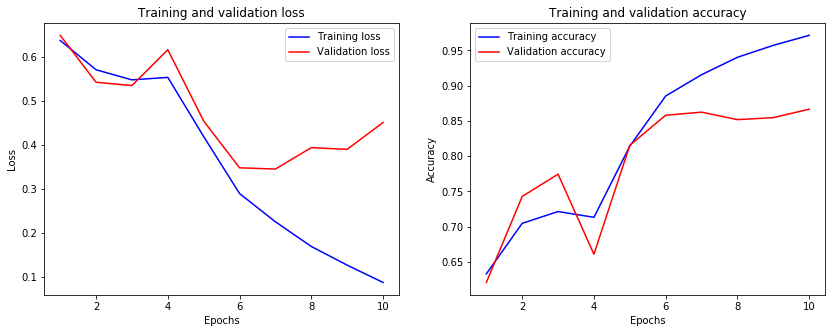

In [0]:
plot_metrics(metrics)

### Model 2 - Fine-tuning a RNN using GloVe Embeddings (1 Bidirectional LSTM layer)

In [0]:
optimizer_v2 = optim.Adam(model_v2.parameters())

metrics = train_evaluate(model_v2, optimizer_v2, criterion, N_EPOCHS)

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 0.661 | Train Acc: 59.09%
	 Val. Loss: 0.620 |  Val. Acc: 65.26%
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.582 | Train Acc: 68.88%
	 Val. Loss: 0.564 |  Val. Acc: 70.76%
Epoch: 03 | Epoch Time: 0m 49s
	Train Loss: 0.485 | Train Acc: 77.70%
	 Val. Loss: 0.403 |  Val. Acc: 83.76%
Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 0.316 | Train Acc: 87.21%
	 Val. Loss: 0.365 |  Val. Acc: 85.14%
Epoch: 05 | Epoch Time: 0m 49s
	Train Loss: 0.246 | Train Acc: 90.42%
	 Val. Loss: 0.311 |  Val. Acc: 88.26%
Epoch: 06 | Epoch Time: 0m 49s
	Train Loss: 0.213 | Train Acc: 92.05%
	 Val. Loss: 0.287 |  Val. Acc: 88.50%
Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 0.172 | Train Acc: 93.69%
	 Val. Loss: 0.353 |  Val. Acc: 87.62%
Epoch: 08 | Epoch Time: 0m 49s
	Train Loss: 0.142 | Train Acc: 95.02%
	 Val. Loss: 0.348 |  Val. Acc: 88.48%
Epoch: 09 | Epoch Time: 0m 49s
	Train Loss: 0.113 | Train Acc: 96.30%
	 Val. Loss: 0.347 |  Val. Acc: 88.36%
Epoch: 10 | Epoch T

In [0]:
test_loss, test_acc = evaluate(model_v2, test_iterator, criterion)

print("Test Loss: {:.3f} |  Test Acc: {:.2f}%".format(test_loss, test_acc*100))

Test Loss: 0.439 |  Test Acc: 86.78%


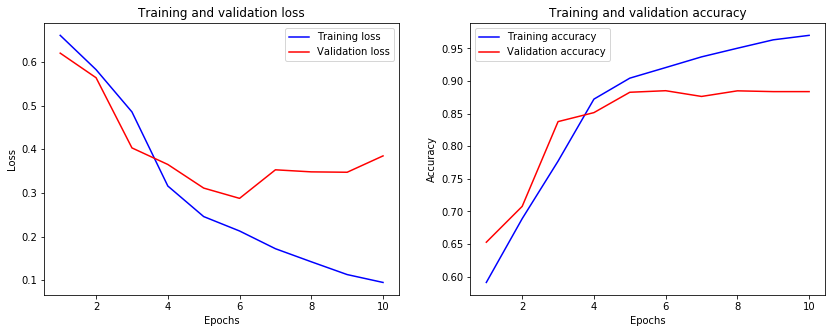

In [0]:
plot_metrics(metrics)

### Model 3 - Training a RNN with a frozen GloVe embeddings (1 Bidirectional LSTM layer)

In [0]:
optimizer_v3 = optim.Adam([p for p in model_v3.parameters() if p.requires_grad])

metrics = train_evaluate(model_v3, optimizer_v3, criterion, N_EPOCHS)

Epoch: 01 | Epoch Time: 0m 48s
	Train Loss: 0.684 | Train Acc: 55.88%
	 Val. Loss: 0.701 |  Val. Acc: 51.04%
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.681 | Train Acc: 56.19%
	 Val. Loss: 0.692 |  Val. Acc: 53.04%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.656 | Train Acc: 59.99%
	 Val. Loss: 0.532 |  Val. Acc: 74.92%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.480 | Train Acc: 78.39%
	 Val. Loss: 0.425 |  Val. Acc: 81.14%
Epoch: 05 | Epoch Time: 0m 49s
	Train Loss: 0.404 | Train Acc: 82.09%
	 Val. Loss: 0.407 |  Val. Acc: 81.06%
Epoch: 06 | Epoch Time: 0m 49s
	Train Loss: 0.376 | Train Acc: 83.63%
	 Val. Loss: 0.377 |  Val. Acc: 83.36%
Epoch: 07 | Epoch Time: 0m 49s
	Train Loss: 0.352 | Train Acc: 84.62%
	 Val. Loss: 0.366 |  Val. Acc: 84.36%
Epoch: 08 | Epoch Time: 0m 49s
	Train Loss: 0.325 | Train Acc: 86.02%
	 Val. Loss: 0.362 |  Val. Acc: 83.92%
Epoch: 09 | Epoch Time: 0m 48s
	Train Loss: 0.303 | Train Acc: 87.19%
	 Val. Loss: 0.371 |  Val. Acc: 83.62%
Epoch: 10 | Epoch T

In [0]:
test_loss, test_acc = evaluate(model_v3, test_iterator, criterion)

print("Test Loss: {:.3f} |  Test Acc: {:.2f}%".format(test_loss, test_acc*100))

Test Loss: 0.394 |  Test Acc: 83.15%


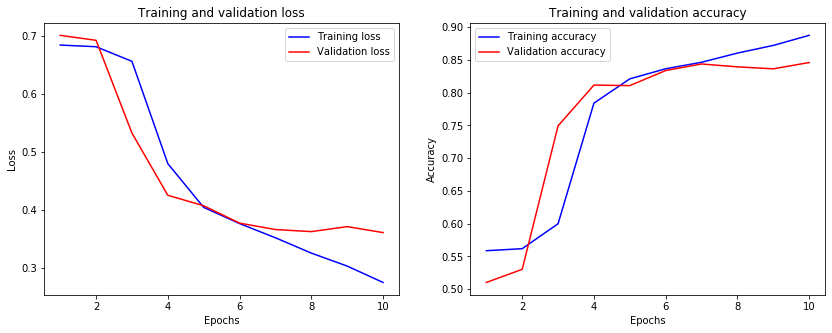

In [0]:
plot_metrics(metrics)

### Model 4 - Fine-tuning a RNN using GloVe embeddings (2 Bidirectional LSTM layers)

In [0]:
optimizer_v4 = optim.Adam(model_v4.parameters())

metrics = train_evaluate(model_v4, optimizer_v4, criterion, N_EPOCHS)

Epoch: 01 | Epoch Time: 2m 1s
	Train Loss: 0.687 | Train Acc: 53.44%
	 Val. Loss: 0.692 |  Val. Acc: 51.10%
Epoch: 02 | Epoch Time: 2m 3s
	Train Loss: 0.688 | Train Acc: 54.18%
	 Val. Loss: 0.678 |  Val. Acc: 57.54%
Epoch: 03 | Epoch Time: 2m 6s
	Train Loss: 0.649 | Train Acc: 62.60%
	 Val. Loss: 0.687 |  Val. Acc: 54.20%
Epoch: 04 | Epoch Time: 2m 7s
	Train Loss: 0.588 | Train Acc: 67.64%
	 Val. Loss: 0.423 |  Val. Acc: 82.64%
Epoch: 05 | Epoch Time: 2m 6s
	Train Loss: 0.328 | Train Acc: 86.47%
	 Val. Loss: 0.313 |  Val. Acc: 86.40%
Epoch: 06 | Epoch Time: 2m 8s
	Train Loss: 0.236 | Train Acc: 90.78%
	 Val. Loss: 0.278 |  Val. Acc: 88.82%
Epoch: 07 | Epoch Time: 2m 7s
	Train Loss: 0.183 | Train Acc: 93.24%
	 Val. Loss: 0.282 |  Val. Acc: 88.92%
Epoch: 08 | Epoch Time: 2m 7s
	Train Loss: 0.148 | Train Acc: 94.72%
	 Val. Loss: 0.338 |  Val. Acc: 88.70%
Epoch: 09 | Epoch Time: 2m 7s
	Train Loss: 0.112 | Train Acc: 96.28%
	 Val. Loss: 0.325 |  Val. Acc: 88.72%
Epoch: 10 | Epoch Time: 2m 7

In [0]:
test_loss, test_acc = evaluate(model_v4, test_iterator, criterion)
print("Test Loss: {:.3f} |  Test Acc: {:.2f}%".format(test_loss, test_acc*100))

Test Loss: 0.373 |  Test Acc: 87.96%


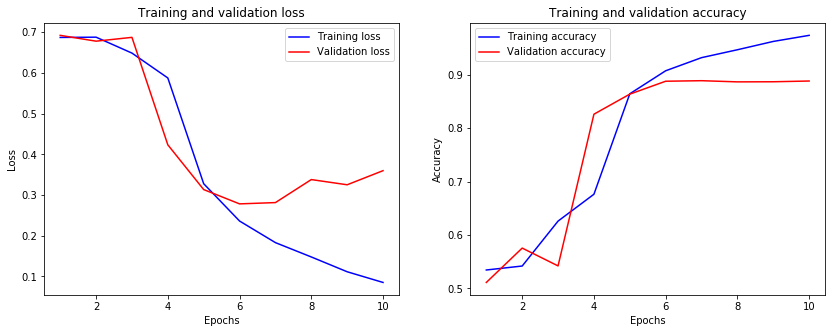

In [0]:
plot_metrics(metrics)